In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
np.random.seed(42)

from keras.datasets import mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train = x_train / 127.5 - 1
x_test = x_test / 127.5 - 1

x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)

In [2]:
################# GAN Model #################
################# GAN Model #################
def build_discriminator():
    input_image = layers.Input(shape=(28,28,1))
    d = layers.Conv2D(32, 4, strides=2, padding='same', activation = 'relu')(input_image)	
    d = layers.Conv2D(64, 4, strides=2, padding='same', activation = 'relu')(d)
    d = layers.Conv2D(128,4, strides=2, padding='same', activation = 'relu')(d)    
    d = layers.Conv2D(256,4, strides=2, padding='same', activation = 'relu')(d)
    d = layers.Conv2D(512,4, strides=2, padding='same', activation = 'relu')(d)        
    d = layers.Flatten()(d)
    d = layers.Dense(128, activation='relu')(d)  
    d = layers.Dropout(0.3)(d)
    d = layers.Dense(128, activation='relu')(d)  
    output = layers.Dense(1, activation='sigmoid')(d)
    model = models.Model(input_image, output)
    model.summary()
    return model

def build_generator(latent_dim):
    # including BatchNormalization layer for the Generator is very important    
    input_layer = layers.Input(shape=(latent_dim,))    
    d = layers.Dense(32, activation='relu', )(input_layer)
    d = layers.BatchNormalization(momentum = 0.8)(d)
    d = layers.Dense(64, activation='relu')(d)
    d = layers.BatchNormalization(momentum = 0.8)(d)
    d = layers.Dense(128, activation='relu')(d)
    d = layers.BatchNormalization(momentum = 0.8)(d)
    d = layers.Dense(256, activation='relu')(d)
    d = layers.BatchNormalization(momentum = 0.8)(d)
    d = layers.Dense(7*7*128, activation='relu')(d)
    d = layers.BatchNormalization(momentum = 0.8)(d)
    d = layers.Reshape((7, 7, 128))(d)    
    # Decoder (Upsampling)   
    d = layers.Conv2DTranspose(128, 3, activation='relu', strides=2, padding='same')(d)  
    d = layers.BatchNormalization(momentum = 0.8)(d)
    output_layer = layers.Conv2DTranspose(1, 3, activation='tanh', strides=2, padding='same')(d)      
    # Output layer
    model = models.Model(inputs=input_layer, outputs=output_layer)
    model.summary()        
    return model

def build_gan(generator, discriminator, latent_dim):
    latent_vector = layers.Input(shape = (latent_dim,))    
    
    fake_img = generator(latent_vector) 
    
    discriminator.trainable = False
    gan_output = discriminator(fake_img)
    
    gan = models.Model(inputs = latent_vector, outputs = gan_output)
    gan.summary()
    return gan

In [3]:
########## Training Function ###########
from tqdm import tqdm
def train(discriminator, generator, latent_dimension, gan, x_train, n_epochs, batch_size):
    d_loss = []
    g_loss = []
    for i in range(n_epochs):
        no_of_iterations = x_train.shape[0]//batch_size	               
        for j in tqdm(range(no_of_iterations)):
            idx = np.random.choice(np.arange(x_train.shape[0]),batch_size)
            real_images = x_train[idx]
            
            latent_vector = np.random.normal(0, 1, (batch_size, latent_dimension))            
            fake_images = generator.predict_on_batch(latent_vector)
            
            discriminator.trainable = True
            ######### Introducing noisy labels during discriminator training to prevent mode collapse:
            if np.random.rand()>0.2:
                d_loss1 = discriminator.train_on_batch(fake_images, np.zeros((batch_size,1)))	
                d_loss2 = discriminator.train_on_batch(real_images, np.ones((batch_size,1)))    
            else:
                d_loss1 = discriminator.train_on_batch(fake_images, np.ones((batch_size,1))) #noisy labels	
                d_loss2 = discriminator.train_on_batch(real_images, np.zeros((batch_size,1))) #noisy labels 
            d_loss.append(0.5*np.add(d_loss1,d_loss2))			
            
            discriminator.trainable = False
            latent_vector = np.random.normal(0, 1, (batch_size, latent_dimension))    
            g_loss.append(gan.train_on_batch(latent_vector , np.ones((batch_size,1))))                
        
        # Generate Random Fake Images at the end of each Epoch
        latent_vector = np.random.normal(0, 1, (5, latent_dimension))     
        fake_images = generator.predict_on_batch(latent_vector)
        for k in range(5):
            plt.subplot(1,5,k+1)
            plt.imshow(fake_images[k])
            plt.axis('off')
        plt.draw()
        plt.pause(0.0001)
        
        print('Epoch = '+str(i+1)+', G Loss = '+str(g_loss[-1])+', D Loss = '+str(d_loss[-1]))    
    return d_loss, g_loss

In [4]:
latent_dimension = 100

discriminator = build_discriminator()
discriminator.compile(optimizer = tf.keras.optimizers.Adam(0.0001, 0.5), loss='binary_crossentropy')

generator = build_generator(latent_dimension)

gan = build_gan(generator, discriminator, latent_dimension)
gan.compile(optimizer =  tf.keras.optimizers.Adam(0.0001, 0.5), loss='binary_crossentropy')

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 14, 14, 32)        544       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 64)          32832     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 4, 128)         131200    
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 2, 2, 256)         524544    
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 1, 1, 512)         2097664   
_________________________________________________________________
flatten (Flatten)            (None, 512)               0     

100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:28<00:00, 16.59it/s]


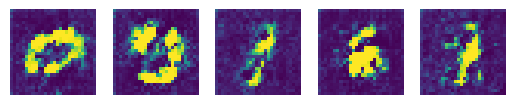

Epoch = 1, G Loss = 0.6634371280670166, D Loss = 0.6734099388122559


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:24<00:00, 19.14it/s]


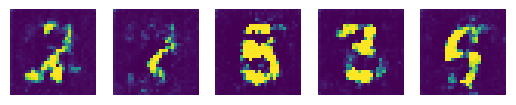

Epoch = 2, G Loss = 0.6961514353752136, D Loss = 0.6887679994106293


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:23<00:00, 19.77it/s]


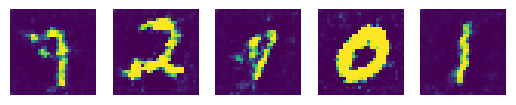

Epoch = 3, G Loss = 0.6828229427337646, D Loss = 0.7014556527137756


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:23<00:00, 19.92it/s]


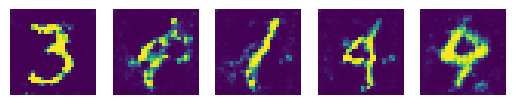

Epoch = 4, G Loss = 0.7023097276687622, D Loss = 0.688887894153595


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:23<00:00, 19.84it/s]


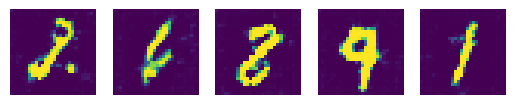

Epoch = 5, G Loss = 0.6970592141151428, D Loss = 0.6883860230445862


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:23<00:00, 19.93it/s]


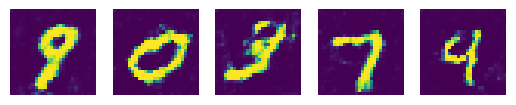

Epoch = 6, G Loss = 0.6893141865730286, D Loss = 0.6998691558837891


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:23<00:00, 19.69it/s]


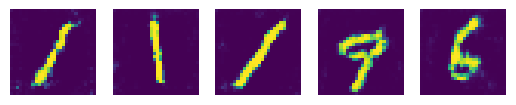

Epoch = 7, G Loss = 0.7610282897949219, D Loss = 0.6698846518993378


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:24<00:00, 18.96it/s]


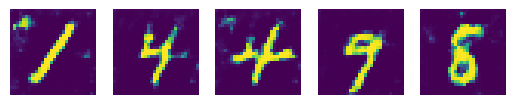

Epoch = 8, G Loss = 0.6908726096153259, D Loss = 0.6819243431091309


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:24<00:00, 18.73it/s]


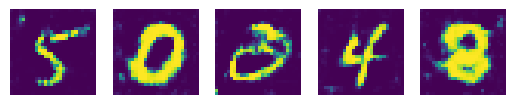

Epoch = 9, G Loss = 0.798668384552002, D Loss = 0.665777862071991


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:25<00:00, 18.68it/s]


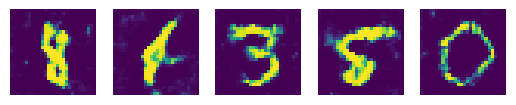

Epoch = 10, G Loss = 0.7782680988311768, D Loss = 0.6594727039337158


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:25<00:00, 18.68it/s]


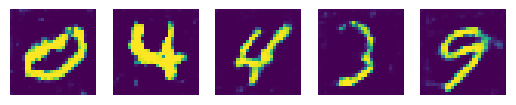

Epoch = 11, G Loss = 0.8642629981040955, D Loss = 0.6473217010498047


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:24<00:00, 18.84it/s]


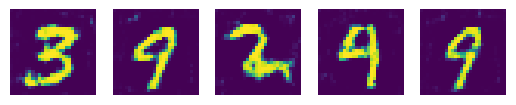

Epoch = 12, G Loss = 0.7832979559898376, D Loss = 0.6602751016616821


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:24<00:00, 18.78it/s]


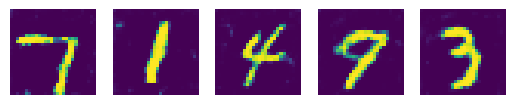

Epoch = 13, G Loss = 0.7905327677726746, D Loss = 0.6585630774497986


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:24<00:00, 18.82it/s]


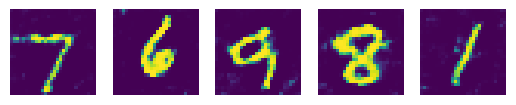

Epoch = 14, G Loss = 0.729672372341156, D Loss = 0.6620674431324005


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:25<00:00, 18.57it/s]


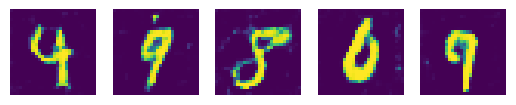

Epoch = 15, G Loss = 0.7223334908485413, D Loss = 0.6717724800109863


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:26<00:00, 17.38it/s]


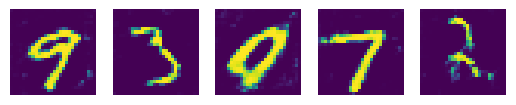

Epoch = 16, G Loss = 0.740033745765686, D Loss = 0.7870840132236481


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:25<00:00, 18.08it/s]


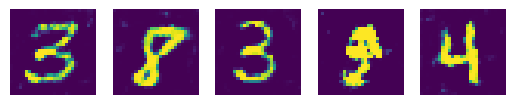

Epoch = 17, G Loss = 0.8308581709861755, D Loss = 0.6278542578220367


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:25<00:00, 18.27it/s]


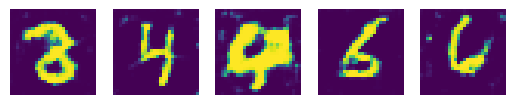

Epoch = 18, G Loss = 0.7508388161659241, D Loss = 0.6545910835266113


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:25<00:00, 18.46it/s]


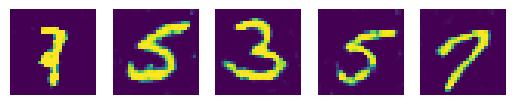

Epoch = 19, G Loss = 0.7906917333602905, D Loss = 0.6166584193706512


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:25<00:00, 18.55it/s]


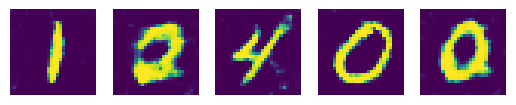

Epoch = 20, G Loss = 0.8766993284225464, D Loss = 0.5870020091533661


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:25<00:00, 18.02it/s]


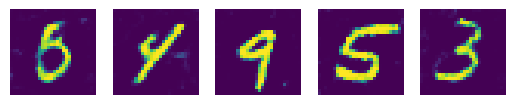

Epoch = 21, G Loss = 0.894078254699707, D Loss = 0.5839107632637024


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:26<00:00, 17.91it/s]


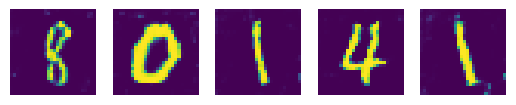

Epoch = 22, G Loss = 0.7566626071929932, D Loss = 0.6392285823822021


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:26<00:00, 17.99it/s]


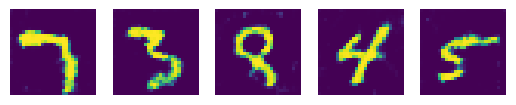

Epoch = 23, G Loss = 0.8597655892372131, D Loss = 0.6193362474441528


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:25<00:00, 18.47it/s]


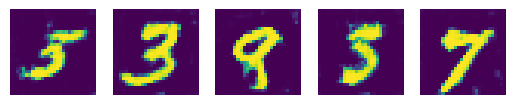

Epoch = 24, G Loss = 0.7704917192459106, D Loss = 0.6537410616874695


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:25<00:00, 18.07it/s]


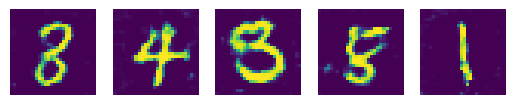

Epoch = 25, G Loss = 0.8309767246246338, D Loss = 0.6357299983501434


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:25<00:00, 18.47it/s]


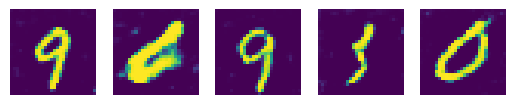

Epoch = 26, G Loss = 0.7670226693153381, D Loss = 0.9097917675971985


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:25<00:00, 18.30it/s]


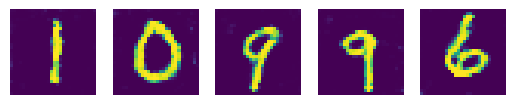

Epoch = 27, G Loss = 0.8320139050483704, D Loss = 0.6159996092319489


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:25<00:00, 18.57it/s]


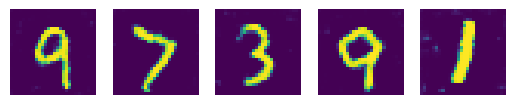

Epoch = 28, G Loss = 0.8399510383605957, D Loss = 0.6396909654140472


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:25<00:00, 18.65it/s]


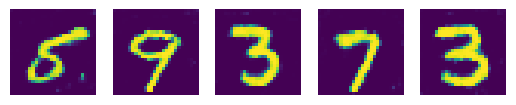

Epoch = 29, G Loss = 0.8275814056396484, D Loss = 0.8682987689971924


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:25<00:00, 18.52it/s]


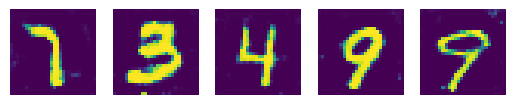

Epoch = 30, G Loss = 0.8153263926506042, D Loss = 0.8691761195659637


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:25<00:00, 18.61it/s]


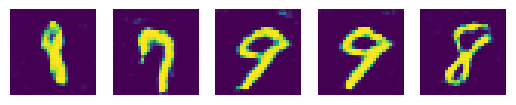

Epoch = 31, G Loss = 0.846595048904419, D Loss = 0.5972565710544586


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:23<00:00, 20.30it/s]


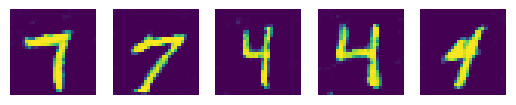

Epoch = 32, G Loss = 0.9477601647377014, D Loss = 0.6002881526947021


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:22<00:00, 20.63it/s]


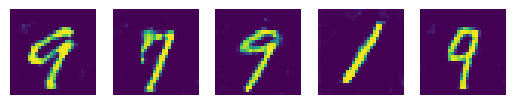

Epoch = 33, G Loss = 0.7787219285964966, D Loss = 0.6481790542602539


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:22<00:00, 20.65it/s]


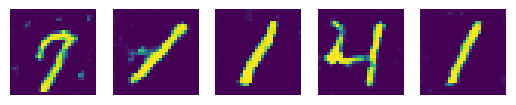

Epoch = 34, G Loss = 0.7365127205848694, D Loss = 0.8080773055553436


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:23<00:00, 20.03it/s]


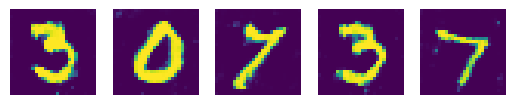

Epoch = 35, G Loss = 0.8758368492126465, D Loss = 0.604294627904892


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:23<00:00, 20.08it/s]


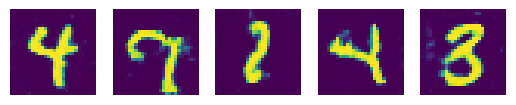

Epoch = 36, G Loss = 0.8477610945701599, D Loss = 0.607528030872345


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:23<00:00, 20.23it/s]


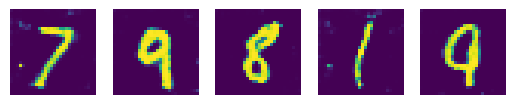

Epoch = 37, G Loss = 0.8153252601623535, D Loss = 0.6256952285766602


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:23<00:00, 20.31it/s]


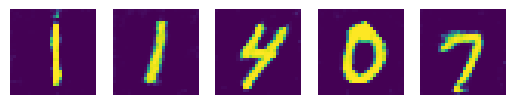

Epoch = 38, G Loss = 0.9418259859085083, D Loss = 0.5461163818836212


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:22<00:00, 21.16it/s]


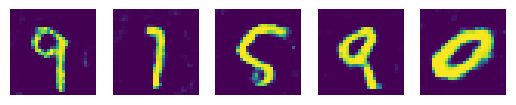

Epoch = 39, G Loss = 0.9418801069259644, D Loss = 0.5774486064910889


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:23<00:00, 20.28it/s]


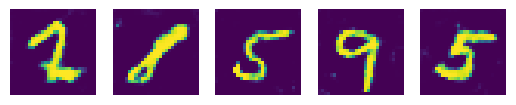

Epoch = 40, G Loss = 0.9052016735076904, D Loss = 0.6039327085018158


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:22<00:00, 20.73it/s]


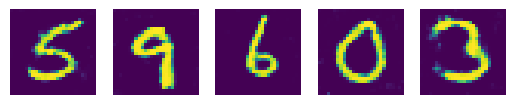

Epoch = 41, G Loss = 0.9693618416786194, D Loss = 0.5438746511936188


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:22<00:00, 20.98it/s]


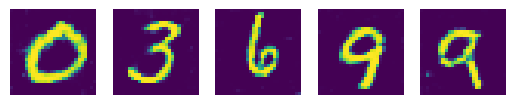

Epoch = 42, G Loss = 0.8639867901802063, D Loss = 0.5844621360301971


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:22<00:00, 20.91it/s]


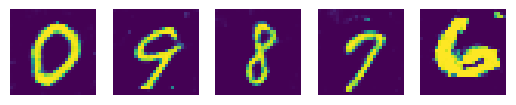

Epoch = 43, G Loss = 0.8244715332984924, D Loss = 0.6165924668312073


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:22<00:00, 20.90it/s]


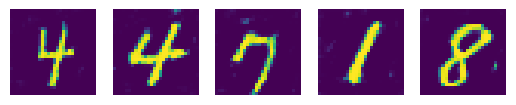

Epoch = 44, G Loss = 0.9444944858551025, D Loss = 0.5844102799892426


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:22<00:00, 20.94it/s]


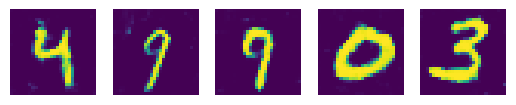

Epoch = 45, G Loss = 0.8859636783599854, D Loss = 0.9157847762107849


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:22<00:00, 20.91it/s]


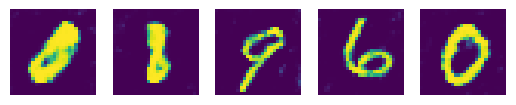

Epoch = 46, G Loss = 0.8546959757804871, D Loss = 0.6085688173770905


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:22<00:00, 20.89it/s]


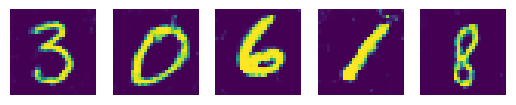

Epoch = 47, G Loss = 0.9215981364250183, D Loss = 0.5527055263519287


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:22<00:00, 20.54it/s]


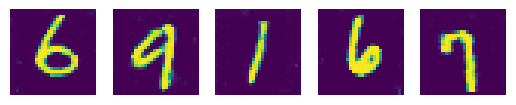

Epoch = 48, G Loss = 0.9060990214347839, D Loss = 1.102673351764679


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:22<00:00, 20.88it/s]


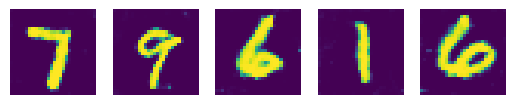

Epoch = 49, G Loss = 0.9451704025268555, D Loss = 0.5503753125667572


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:22<00:00, 20.40it/s]


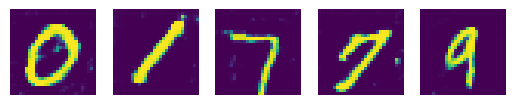

Epoch = 50, G Loss = 0.8722907304763794, D Loss = 0.5915281176567078


In [5]:
d_loss, g_loss = train(discriminator, generator, latent_dimension, gan, x_train, n_epochs = 50, batch_size = 128)

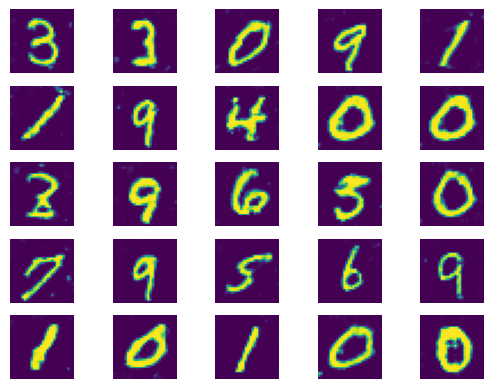

In [11]:
##### Sample Examples #######
latent_vector = np.random.normal(0, 1, (25, latent_dimension))     
fake_images = generator.predict_on_batch(latent_vector)
for k in range(25):
    plt.subplot(5,5,k+1)
    plt.imshow(fake_images[k])
    plt.axis('off')
plt.draw()
plt.pause(0.0001)